# Effective models for winning football games
Comparison between Expected Threat (xT) and Expected Goals (xG) as effective models for winning games 

In [1]:
import pandas as pd
import numpy as np
import statsbombpy
from statsbombpy import sb

from tqdm.notebook import tqdm
import socceraction.spadl as spadl
import socceraction.spadl.statsbomb as statsbomb
import socceraction.classification.features as fs
import socceraction.xthreat as xthreat

import matplotsoccer as mps
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import os; import sys; sys.path.insert(0,'../')
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

Requirements:  
- pandas 0.25.1
- numpy 1.16.5 
- matplotlib 3.2.1
- seaborn 0.9.0
- sklearn 0.21.3
- statsbombpy  
- socceraction  
- tqdm  

In [2]:
free_open_data_remote = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
SBL = statsbomb.StatsBombLoader(root=free_open_data_remote,getter="remote")
competitions = SBL.competitions()

 # FA Women's Super League
selected_competitions = competitions[competitions.competition_name=="FA Women's Super League"]
selected_competitions

# Get matches from all selected competitions
matches = list(
    SBL.matches(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
)
matches = pd.concat(matches, sort=True).reset_index(drop=True)
matches[["home_team_name","away_team_name","match_date","home_score","away_score"]].head()

,home_team_name,away_team_name,match_date,home_score,away_score
0,Reading WFC,West Ham United LFC,2020-02-12,2,0
1,Manchester City WFC,Arsenal WFC,2020-02-02,2,1
2,Brighton & Hove Albion WFC,Everton LFC,2020-02-02,1,0
3,Brighton & Hove Albion WFC,Tottenham Hotspur Women,2020-02-23,0,1
4,Birmingham City WFC,Everton LFC,2019-09-08,0,1


In [3]:
matches_verbose = tqdm(list(matches.itertuples()),desc="Loading match data")
teams,players,player_games = [],[],[]
actions = {}
for match in matches_verbose:
    # load data
    teams.append(SBL.teams(match.match_id))
    players.append(SBL.players(match.match_id))
    events = SBL.events(match.match_id)
    
    # convert data
    player_games.append(statsbomb.extract_player_games(events))
    actions[match.match_id] = statsbomb.convert_to_actions(events,match.home_team_id)

games = matches.rename(columns={"match_id":"game_id"})
teams = pd.concat(teams).drop_duplicates("team_id").reset_index(drop=True)
players = pd.concat(players).drop_duplicates("player_id").reset_index(drop=True)
player_games = pd.concat(player_games).reset_index(drop=True)

In [4]:
datafolder = "../data"
# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created ")

spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players
    spadlstore["player_games"] = player_games
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = actions[game_id]

    spadlstore["actiontypes"] = spadl.actiontypes_df()
    spadlstore["results"] = spadl.results_df()
    spadlstore["bodyparts"] = spadl.bodyparts_df()
    
games = pd.read_hdf(spadl_h5,"games")
print("nb of games:", len(games))

actiontypes = pd.read_hdf(spadl_h5, "actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")
results = pd.read_hdf(spadl_h5, "results")

nb of games: 194


In [5]:
def create_ActionsDf_from_spadl_h5(spadl_h5, team_id):
    ## Select games
    A = []
    for game in list(games.itertuples()):
        actions = pd.read_hdf(spadl_h5,f"actions/game_{game.game_id}")
        actions = actions[actions.team_id == team_id] 
        actions = (
            actions.merge(actiontypes,how="left")
            .merge(results,how="left")
            .merge(bodyparts,how="left")
            .sort_values(["period_id", "time_seconds", "timestamp"])  
        )
        [actions] = fs.play_left_to_right([actions],game.home_team_id)
        A.append(actions) 
    A = pd.concat(A)
    return A

d = {}
for index, row in tqdm(teams.iterrows(), total=len(teams)):
    d[row.team_name] = pd.DataFrame()
    d[row.team_name] = create_ActionsDf_from_spadl_h5(spadl_h5, row.team_id)
    d[row.team_name] = d[row.team_name].reset_index(drop=True)

C:\Users\Milan\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


In [6]:
#Create Expected Threat (xT) and move actions dictionaries of all teams. 
xTModels = {}
dict_mov_actions = {}
dict_mov_actions_success = {}

for index, row in tqdm(teams.iterrows(), total=len(teams)):
    ACTIONS = d[row.team_name] 
    xTModels[row.team_name] = xthreat.ExpectedThreat(l=16, w=12)
    xTModels[row.team_name].fit(ACTIONS)
    mov_actions = xthreat.get_move_actions(ACTIONS)
    mov_actions_success = xthreat.get_successful_move_actions(ACTIONS)
    # Add the xT value to the dataframes
    mov_actions["xT"] = xTModels[row.team_name].predict(mov_actions)
    mov_actions_success["xT"] = xTModels[row.team_name].predict(mov_actions_success)
    dict_mov_actions[row.team_name] = mov_actions
    dict_mov_actions_success[row.team_name] = mov_actions_success

# iterations:  35


C:\Users\Milan\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


# iterations:  34
# iterations:  52
# iterations:  57
# iterations:  31
# iterations:  29
# iterations:  34
# iterations:  41
# iterations:  29
# iterations:  44
# iterations:  28
# iterations:  39
# iterations:  26



West Ham United LFC:


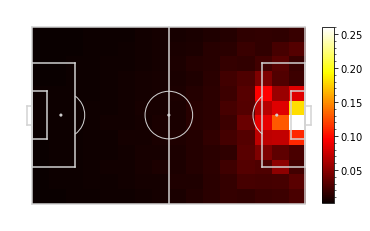

Reading WFC:


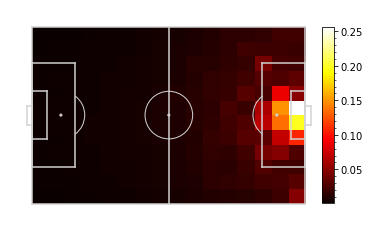

Manchester City WFC:


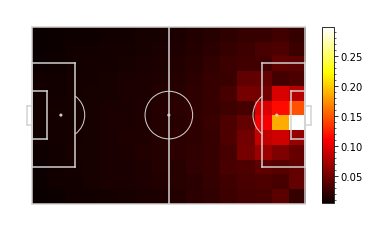

Arsenal WFC:


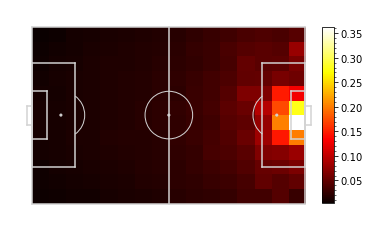

Everton LFC:


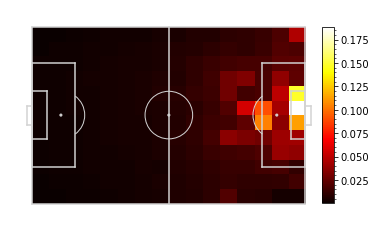

Brighton & Hove Albion WFC:


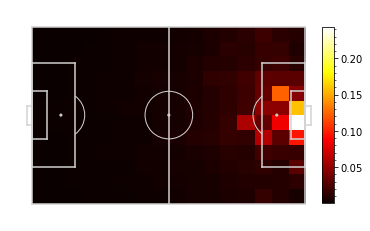

Tottenham Hotspur Women:


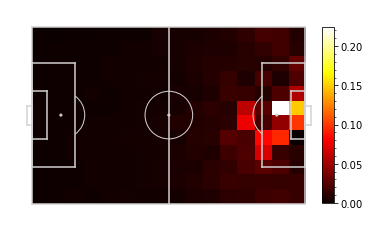

Birmingham City WFC:


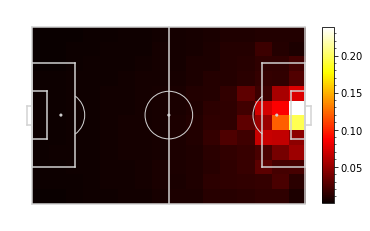

Liverpool WFC:


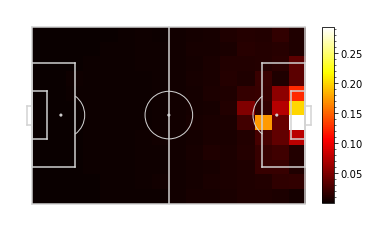

Chelsea FCW:


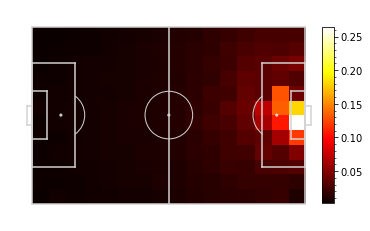

Bristol City WFC:


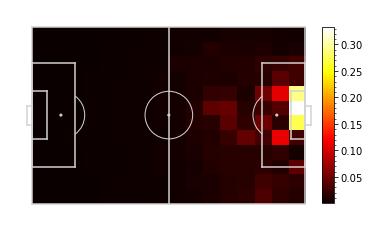

Manchester United:


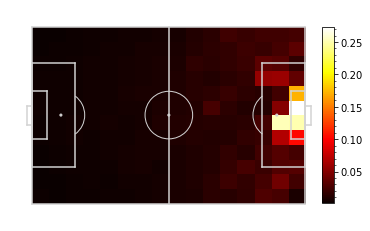

Yeovil Town LFC:


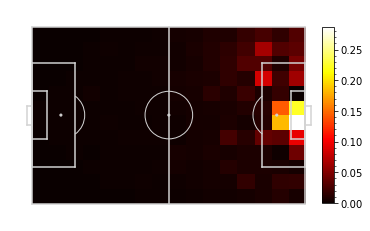

In [7]:
for index, row in teams.iterrows():
    print(row.team_name +':')
    mps.heatmap(xTModels[row.team_name].xT,cmap="hot",linecolor="lightgrey",cbar="True")

Create a new matches dataframe called df_matches. 

In [8]:

# Addding cumulative xG per match to the matches dataframe.
# This will take a while to LOAD, see tqdm progress bar
df_matches =matches[["home_team_name","away_team_name","match_id","match_date",
                          "home_score","away_score"]].copy()
xG_home_list = []
xG_away_list = []
xG_list = []
for row in tqdm(matches.itertuples(), total = len(matches)):
    df_shots = sb.events(match_id=row.match_id, split=True)["shots"];
    xG_list = np.array(pd.DataFrame(df_shots.shot).stack().str['statsbomb_xg'].unstack().shot)
    df_shots['xG'] = xG_list.tolist()
    df_shots_home = df_shots[df_shots.team == row.home_team_name]
    df_shots_away = df_shots[df_shots.team == row.away_team_name]
    xG_home_list.append(df_shots_home.xG.sum())
    xG_away_list.append(df_shots_away.xG.sum())

df_matches['xG_home'] = xG_home_list
df_matches['xG_away'] = xG_away_list

# Make a new dataframe of all matches including important features
df_matches['xG_diff_home_away']= np.nan
df_matches['xT_diff_home_away']= np.nan
df_matches['goal_difference']= np.nan
df_matches['winning_team']= np.nan
df_matches['xT_home'] = np.nan
df_matches['xT_away'] = np.nan 
i = 0
for row in matches.itertuples():
    df_matches['goal_difference'].iloc[i] = row.home_score -row.away_score
    game_id = df_matches.iloc[i].match_id
    #Home team
    temp_d = dict_mov_actions_success[df_matches.iloc[i].home_team_name]
    temp_mov_actions = temp_d[temp_d.game_id == game_id]
    df_matches['xT_home'].iloc[i] = temp_mov_actions.xT.sum()
    #Away team
    temp_d = dict_mov_actions_success[df_matches.iloc[i].away_team_name]
    temp_mov_actions = temp_d[temp_d.game_id == game_id]
    df_matches['xT_away'].iloc[i] = temp_mov_actions.xT.sum()
    
    df_matches['xT_diff_home_away'].iloc[i] = df_matches['xT_home'].iloc[i] - df_matches['xT_away'].iloc[i]
    df_matches['xG_diff_home_away'].iloc[i] = df_matches['xG_home'].iloc[i] - df_matches['xG_away'].iloc[i]
    
    if row.home_score > row.away_score:
        df_matches['winning_team'].iloc[i] = 1
    if row.away_score > row.home_score:
        df_matches['winning_team'].iloc[i]  = -1 
    if row.away_score == row.home_score:
        df_matches['winning_team'].iloc[i]  = 0 
    i += 1

credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data acces

credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data acces

C:\Users\Milan\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
# Make a new dataframe of all matches including important features
df_matches['xG_diff_home_away']= np.nan
df_matches['xT_diff_home_away']= np.nan
df_matches['goal_difference']= np.nan
df_matches['winning_team']= np.nan
df_matches['xT_home'] = np.nan
df_matches['xT_away'] = np.nan 
i = 0
for row in matches.itertuples():
    df_matches['goal_difference'].iloc[i] = row.home_score -row.away_score
    game_id = df_matches.iloc[i].match_id
    #Home team
    temp_d = dict_mov_actions_success[df_matches.iloc[i].home_team_name]
    temp_mov_actions = temp_d[temp_d.game_id == game_id]
    df_matches['xT_home'].iloc[i] = temp_mov_actions.xT.sum()
    #Away team
    temp_d = dict_mov_actions_success[df_matches.iloc[i].away_team_name]
    temp_mov_actions = temp_d[temp_d.game_id == game_id]
    df_matches['xT_away'].iloc[i] = temp_mov_actions.xT.sum()
    
    df_matches['xT_diff_home_away'].iloc[i] = df_matches['xT_home'].iloc[i] - df_matches['xT_away'].iloc[i]
    df_matches['xG_diff_home_away'].iloc[i] = df_matches['xG_home'].iloc[i] - df_matches['xG_away'].iloc[i]
    
    if row.home_score > row.away_score:
        df_matches['winning_team'].iloc[i] = 1
    if row.away_score > row.home_score:
        df_matches['winning_team'].iloc[i]  = -1 
    if row.away_score == row.home_score:
        df_matches['winning_team'].iloc[i]  = 0 
    i += 1

Create the first two Figures and correlation heatmap

In [10]:
def apply_Lin_Regression_return_r2score_string(column_name_x, column_name_y, df):
    from sklearn.linear_model import LinearRegression
    X = df[column_name_x].copy().values.reshape(-1,1)
    y = df[column_name_y].copy().values.reshape(-1,1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    linearRegr = LinearRegression()
    linearRegr.fit(X_train, y_train)
    r2_score = linearRegr.score(X_test, y_test)
    return r2_score

def plot_JointGrid(str_x, str_y, r2score): 
    g = sns.JointGrid(str_x,"goal difference", temp_df)
    for winning_team, winning_teams in temp_df.groupby("winning_team"):
        if winning_team == -1:
            sns.kdeplot(winning_teams[str_x], ax=g.ax_marg_x, legend=False, color = list(cmap[10]))
            sns.kdeplot(winning_teams[str_y], ax=g.ax_marg_y, vertical=True, legend=False, color = list(cmap[10]))
            g.ax_joint.plot(winning_teams[str_x],winning_teams[str_y], 
                            "o", ms=5, color = list(cmap[10]))
        elif winning_team == 0:
            sns.kdeplot(winning_teams[str_x], ax=g.ax_marg_x, legend=False, color = 'black')
            sns.kdeplot(winning_teams[str_y], ax=g.ax_marg_y, vertical=True, legend=False, color = 'black')
            g.ax_joint.plot(winning_teams[str_x],winning_teams[str_y], 
                            "o", ms=5, color = 'black')
        elif winning_team == 1:
            sns.kdeplot(winning_teams[str_x], ax=g.ax_marg_x, legend=False, color = list(cmap[190]))
            sns.kdeplot(winning_teams[str_y], ax=g.ax_marg_y, vertical=True, legend=False, color = list(cmap[190]))
            g.ax_joint.plot(winning_teams[str_x],winning_teams[str_y], 
                            "o", ms=5, color = list(cmap[190]))    

    sns.regplot(temp_df[str_x], temp_df[str_y], 
                    ax=g.ax_joint, scatter=False, color = 'grey'
                   )
    plt.text(-2.1, -8, 'r2 = '+ str(round(r2_score,2)), fontsize=9) #add text
    plt.text(-1.2, 11, 'Scatterplot: ' + str_y + ' against ' + str_x.split('_')[0],
             horizontalalignment='center',
             fontsize=10, fontweight='bold'
            )
    plt.legend(labels=['loss' , 'draw', 'win'], loc='lower right', bbox_to_anchor=(-0.25, 0))

r2 score = 0.49237506606446513


C:\Users\Milan\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Milan\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


r2 score = 0.62699941376372


C:\Users\Milan\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Milan\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


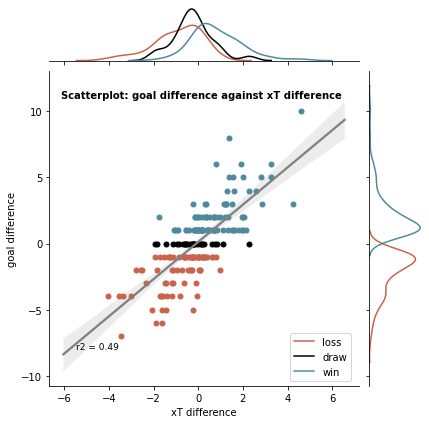

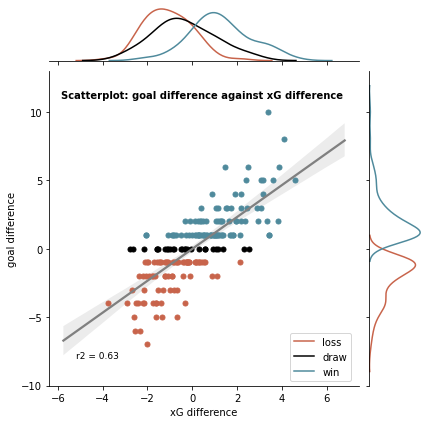

In [12]:
cmap = sns.diverging_palette(20, 220, n=200)
#Plot Figure 2, xT plot
temp_df = df_matches[["xT_diff_home_away","goal_difference",'winning_team']].copy()
temp_df.columns = ['xT difference', 'goal difference', 'winning_team']
r2_score = apply_Lin_Regression_return_r2score_string("xT difference",'goal difference', temp_df)
print('r2 score = ' + str(r2_score))
plot_JointGrid("xT difference","goal difference", r2_score)


#Plot Figure 3, xG plot
temp_df = df_matches[["xG_diff_home_away","goal_difference",'winning_team']].copy()
temp_df.columns = ['xG difference', 'goal difference', 'winning_team']
r2_score = apply_Lin_Regression_return_r2score_string("xG difference",'goal difference',temp_df)
print('r2 score = ' + str(r2_score))
plot_JointGrid("xG difference","goal difference", r2_score)

Text(0.5, 1.0, 'Correlation heatmap: goal difference')

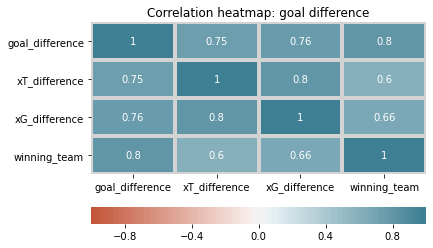

In [13]:
#Plot correlation heatmap
temp_data = df_matches.copy()
temp_data = temp_data[['goal_difference', 'xT_diff_home_away','xG_diff_home_away','winning_team']]
temp_data.columns = ['goal_difference', 'xT_difference', 'xG_difference', 'winning_team']
#matrix = np.triu(temp_data.corr())

sns.heatmap(temp_data.corr(), annot=True, vmin=-1, vmax=1, center= 0, cmap=sns.diverging_palette(20, 220, n=200),
            linewidths=3, linecolor='lightgrey',  cbar_kws={'orientation': 'horizontal'})#, mask=matrix)
plt.title('Correlation heatmap: goal difference')

Create New Data Frame of the goals scored of each team per match, their cumulative xT and cumulative xG.

In [14]:
#Create a new list of the goals scored of both the home team and the away team
list_goals = df_matches.home_score.append(df_matches.away_score).reset_index(drop=True)
df_xT_and_xG = pd.DataFrame(list_goals, columns=['goals'])
df_xT_and_xG['xT'] = df_matches.xT_home.append(df_matches.xT_away).reset_index(drop=True).copy() 
df_xT_and_xG['xG'] = df_matches.xG_home.append(df_matches.xG_away).reset_index(drop=True).copy()
df_xT_and_xG.head()

,goals,xT,xG
0,2,1.261291,2.171574
1,2,0.936533,0.626863
2,1,0.613950,0.957089
3,0,0.392540,0.552542
4,0,0.840968,0.750631


Text(-500, 10.5, 'Hexplot: goals scored against xG')

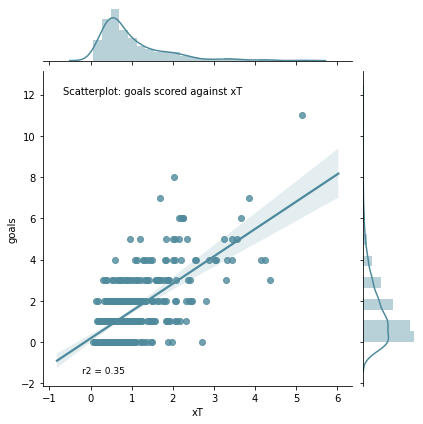

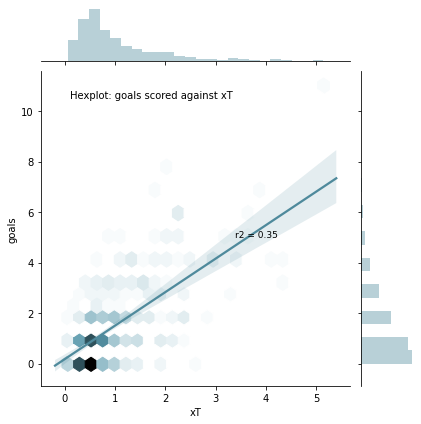

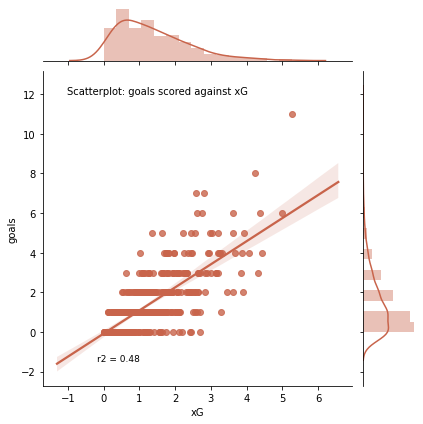

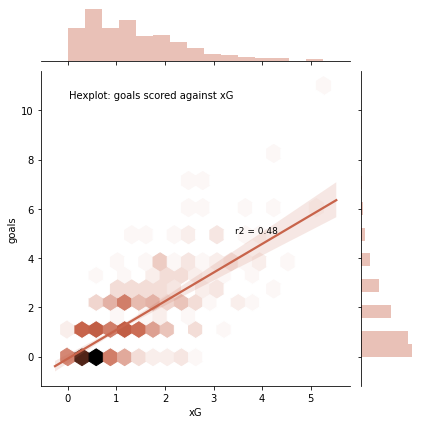

In [15]:
# Calculation of Linear Regression and plots for xT
r2_score = apply_Lin_Regression_return_r2score_string('xT', 'goals', df_xT_and_xG)

sns.jointplot(x='xT', y='goals', data=df_xT_and_xG, kind="reg", color = list(cmap[190]));
plt.text(-0.2, -1.5, 'r2 = '+ str(round(r2_score,2)), fontsize=9) #add text
plt.text(1.5, 12, 'Scatterplot: goals scored against xT',
         horizontalalignment='center',
         fontsize=10
        )

g = sns.jointplot(x='xT', y='goals', data=df_xT_and_xG, kind="hex",  color = list(cmap[190]))
sns.regplot(df_xT_and_xG.xT, df_xT_and_xG.goals, ax=g.ax_joint, scatter=False, color = list(cmap[190]))
plt.text(-300,5, 'r2 = '+ str(round(r2_score,2)), fontsize=9) #add text
plt.text(-500, 10.5, 'Hexplot: goals scored against xT',
         horizontalalignment='center',
         fontsize=10
        )

# Calculation of Linear Regression and plots for xG
r2_score = apply_Lin_Regression_return_r2score_string('xG', 'goals', df_xT_and_xG)

sns.jointplot(x='xG', y='goals', data=df_xT_and_xG, kind="reg", color = list(cmap[10]));
plt.text(-0.2, -1.5, 'r2 = '+ str(round(r2_score,2)), fontsize=9) #add text
plt.text(1.5, 12, 'Scatterplot: goals scored against xG',
         horizontalalignment='center',
         fontsize=10
        )

g = sns.jointplot(x='xG', y='goals', data=df_xT_and_xG, kind="hex", color = list(cmap[10]))
sns.regplot(df_xT_and_xG.xG, df_xT_and_xG.goals, ax=g.ax_joint, scatter=False, color = list(cmap[10]))
plt.text(-300, 5, 'r2 = '+ str(round(r2_score,2)), fontsize=9) #add text
plt.text(-500, 10.5, 'Hexplot: goals scored against xG',
         horizontalalignment='center',
         fontsize=10
        )